In [1]:
%pip install geopandas pyroj rasterstats pygeos


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 102.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 16.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import rasterio
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
from shapely.ops import nearest_points
from shapely.geometry import LineString, Point
import networkx as nx

/usr/local/lib/python3.10/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<ipython-input-2-dbfd456ace92>:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling Py

In [3]:
# Defining Coordinate Reference System to use throughout the whole notebook
wgs84_crs = CRS.from_string('EPSG:4326') # WGS 1984
aeaa_crs = CRS.from_string("esri:102022") # albers equal area africa crs
aedc_crs = CRS.from_string("esri:102023") # Africa equidistant conic

In [4]:
#Set up google colab and directories
mainpath="/content/drive"
inpath="{}/MyDrive/GIS_Research_2023/assignment/solutions/data".format(mainpath)
outpath="{}/MyDrive/GISworkspace/data_lecture3".format(mainpath)

from google.colab import drive
drive.mount(mainpath)

Mounted at /content/drive


1. Identifying tanzanian Cities

In [5]:
cities = pd.read_csv(inpath+'/cleaned/cities/citypop_v4_latlons.csv')
cities = gpd.GeoDataFrame(cities[cities.iso3v10=='TZA'],
                          geometry = gpd.points_from_xy(cities[cities.iso3v10=='TZA']['lon'],
                                                        cities[cities.iso3v10=='TZA']['lat']),
                          crs = wgs84_crs)[['name', 'pop', 'geometry']].reset_index(drop=True).copy()
cities = cities.to_crs(aedc_crs)
cities['pop'] = cities['pop'].str.replace(',', '').astype('int')

light_polys = gpd.read_file(inpath+'/cleaned/city_extents/city_extents.shp').to_crs(aedc_crs)
sjpts = gpd.sjoin_nearest(cities, light_polys, how="left", distance_col="sjdist")
sjpts['sjdist_km'] = sjpts.sjdist/1000
sjpts['maxpop'] = sjpts.groupby('FID')['pop'].transform('max')
# discard points distant more than 5km from a lights polygon and those with population not equal
# to the population of the largest city joined to a lights polygon
sjpts = sjpts[(sjpts.sjdist_km<=5) & (sjpts['pop']==sjpts['maxpop'])][['name', 'pop', 'FID', 'geometry']].reset_index(drop=True).to_crs(wgs84_crs).copy()
lights_cities = pd.merge(light_polys, sjpts.drop('geometry', axis=1), on=['FID'], how='inner').to_crs(wgs84_crs)

2.Computing total light emitted by each city in 1992 and 2013

In [6]:
lights_1992 = rasterio.open(inpath+'/cleaned/lights/tza_lights_1992.tif')
lights_2013 = rasterio.open(inpath+'/cleaned/lights/tza_lights_2013.tif')
zs92 = zonal_stats(lights_cities,
                   lights_1992.read(1).astype(float),
                   affine=lights_1992.profile['transform'],
                   stats=['sum'],
                   nodata=np.nan,
                   all_touched=True)
zs13 = zonal_stats(lights_cities,
                   lights_2013.read(1).astype(float),
                   affine=lights_2013.profile['transform'],
                   stats=['sum'],
                   nodata=np.nan,
                   all_touched=True)
lights_cities['lights92'] = [x['sum'] for x in zs92]
lights_cities['lights13'] = [x['sum'] for x in zs13]

 Scatterplots of population against night lights

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


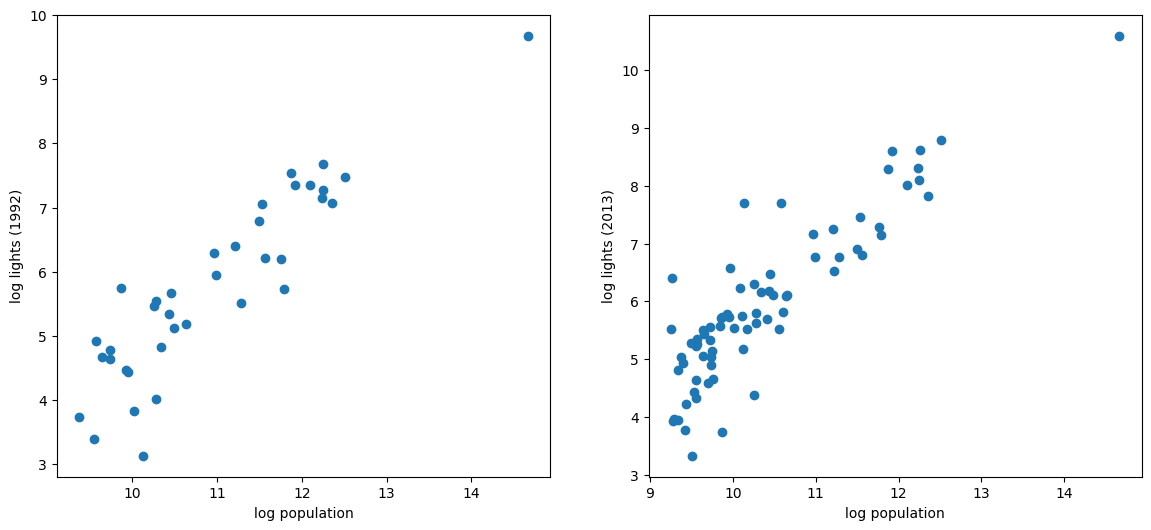

In [7]:
f, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(np.log(lights_cities['pop']), np.log(lights_cities['lights92']))
ax[1].scatter(np.log(lights_cities['pop']), np.log(lights_cities['lights13']))
ax[0].set_xlabel('log population')
ax[1].set_xlabel('log population')
ax[0].set_ylabel('log lights (1992)')
ax[1].set_ylabel('log lights (2013)')
plt.show(f)

3. Identifying Tanzanian Primary Cities

In [8]:
tza_poly = gpd.read_file(inpath+'/cleaned/tza_poly/tza_polygon.shp')
sjpts[sjpts['pop'] == sjpts['pop'].max()]

,name,pop,FID,geometry
9,Dar es Salaam,2339910,167.0,POINT (39.28555 -6.81833)


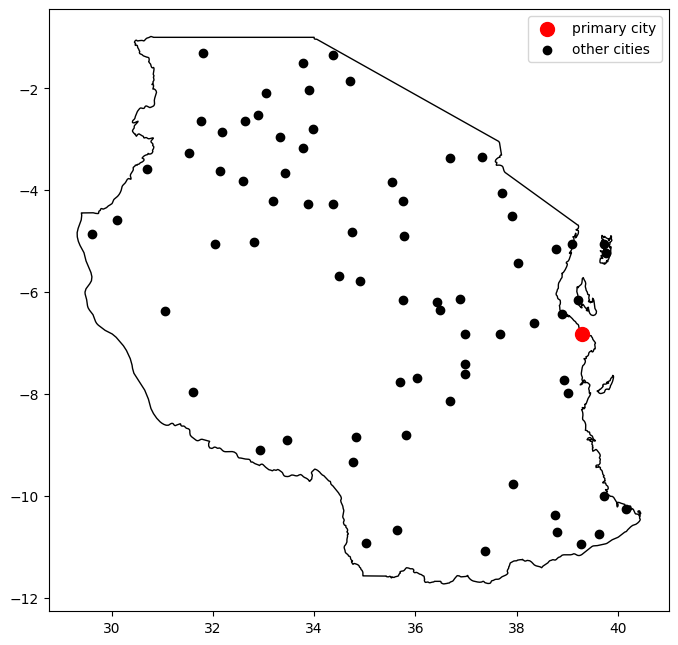

In [9]:
f, ax = plt.subplots(1,1, figsize=(8,8))
tza_poly.plot(ax=ax, color='white', edgecolor='black')
sjpts[sjpts['name'] == 'Dar es Salaam'].plot(ax=ax, color='r', markersize=100, label='primary city')
sjpts[sjpts['name'] != 'Dar es Salaam'].plot(ax=ax, color='k', label='other cities')
ax.legend()
plt.show(f)

4. Creating a routable road network

In [10]:
roads = gpd.read_file(inpath+'/cleaned/roads/roads.shp').to_crs(aedc_crs)
roads["adm0"]=1
dissolved_roads = roads.dissolve(by='adm0').geometry
del roads['adm0']

sjpts = sjpts.to_crs(aedc_crs)
sjpts['closest_point_on_roads'] = sjpts.apply(lambda x: nearest_points(dissolved_roads.geometry[1],
                                              x['geometry'])[0], axis=1)
# sjpts = sjpts.to_crs(wgs84_crs)

connectors_roads = sjpts.copy()
connectors_roads['geometry'] = connectors_roads.apply(lambda x: LineString([x['geometry'], x['closest_point_on_roads']]), axis=1)

sjpts = sjpts[['name', 'pop', 'FID', 'geometry']].copy()
connectors_roads = connectors_roads[['FID', 'geometry']].copy()

4.2. Dealing with connectivity issues

In [11]:
connectors_roads_scaled = connectors_roads.copy()
connectors_roads_scaled['geometry'] = connectors_roads_scaled.geometry.scale(xfact = 1.00001, yfact = 1.00001)
# Mtwara requires special treatment because its connector is very short and scaling it by 1.00001 is not enough for it to reach the road
connectors_roads_scaled.loc[connectors_roads_scaled.FID==227, 'geometry'] = (
    connectors_roads_scaled.loc[connectors_roads_scaled.FID==227, 'geometry'].scale(xfact = 1.05, yfact = 1.05)
)

connectors_roads_scaled

,FID,geometry
0,58.0,"LINESTRING (1209274.472 -376163.652, 1209286.9..."
1,83.0,"LINESTRING (1112237.975 -468319.357, 1111997.5..."
2,153.0,"LINESTRING (1436141.341 -716769.688, 1436484.4..."
3,25.0,"LINESTRING (929815.441 -311321.882, 929724.324..."
4,3.0,"LINESTRING (704437.880 -146659.416, 704342.331..."
...,...,...
69,104.0,"LINESTRING (728887.328 -561251.329, 729082.490..."
70,46.0,"LINESTRING (676183.716 -362199.750, 679630.330..."
71,213.0,"LINESTRING (819076.784 -1008837.322, 818986.34..."
72,102.0,"LINESTRING (1522112.583 -564646.532, 1523022.5..."


snapping the cities' location to the rescaled connectors.

In [12]:
def snap_points_to_modified_connectors(points_gdf, connectors_gdf):

    out = points_gdf.copy()

    for index, row in points_gdf.iterrows():

        tmp_gdf = connectors_gdf.copy()
        tmp_gdf['distance'] = tmp_gdf.distance(row['geometry'])
        closest_geom = list(tmp_gdf.sort_values('distance')['geometry'])[0]
        closest_pts = [Point(coords) for coords in closest_geom.coords]
        dists = [row['geometry'].distance(x) for x in closest_pts]
        minimum = min(dists)
        minimum_index = [i for i, j in enumerate(dists) if j == minimum][0]
        out.loc[index, 'geometry'] = closest_pts[minimum_index]

    return out

The function above is used to snap the identified city to the rescale connectors

In [13]:
modified_centroids = snap_points_to_modified_connectors(sjpts, connectors_roads_scaled)

4.3 Joining roads and connectors

In [14]:
roads['transport_type'] = roads['surface']
del roads['surface']
connectors_roads_scaled['transport_type'] = 'paved'

joined_scaled = pd.concat([roads, connectors_roads_scaled])

uun_joined_scaled = gpd.GeoDataFrame({'geometry': list(joined_scaled.geometry.unary_union.geoms)},
                                     index = np.arange(len(joined_scaled.geometry.unary_union.geoms)), crs = aedc_crs)
joined_scaled_buff = joined_scaled.copy()
joined_scaled_buff.geometry = joined_scaled_buff.geometry.buffer(0.0001)
uun_joined_scaled = gpd.tools.sjoin(uun_joined_scaled, joined_scaled_buff, how="inner", op='within').drop(['index_right'], axis=1)

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


4.4 Examining connectivity

In [15]:
# taken from here:
# https://www.reddit.com/r/gis/comments/b1ui7h/geopandas_how_to_make_a_graph_out_of_a/

def gdf_to_nx(gdf_network):
    # generate graph from GeoDataFrame of LineStrings
    net = nx.Graph()
    net.graph['crs'] = gdf_network.crs
    fields = list(gdf_network.columns)

    for index, row in gdf_network.iterrows():
        first = row.geometry.coords[0]
        last = row.geometry.coords[-1]

        data = [row[f] for f in fields]
        attributes = dict(zip(fields, data))
        net.add_edge(first, last, **attributes)

    return net

Generating a geodataframe with the number of connected components for each city

In [16]:
nw_scaled = gdf_to_nx(uun_joined_scaled)
centlist_mod = [(x.xy[0][0], x.xy[1][0]) for x in modified_centroids.geometry]
cclist_scaled = list(nx.connected_components(nw_scaled))

n_ccomps_scaled = []

for i, cent_data in enumerate(centlist_mod):
    for ccs in cclist_scaled:
        if cent_data in ccs:
            n_ccomps_scaled.append((cent_data, sjpts.iloc[i]['name'], len(ccs)))

ccomps_scaled_df = pd.DataFrame(n_ccomps_scaled, columns = ['centroid_coordinates', 'city_name', 'number_connected_components'])
ccomps_scaled_df['geometry'] = [Point(x) for x in ccomps_scaled_df.centroid_coordinates]
ccomps_scaled_df = gpd.GeoDataFrame(ccomps_scaled_df, crs = aedc_crs)

plotting

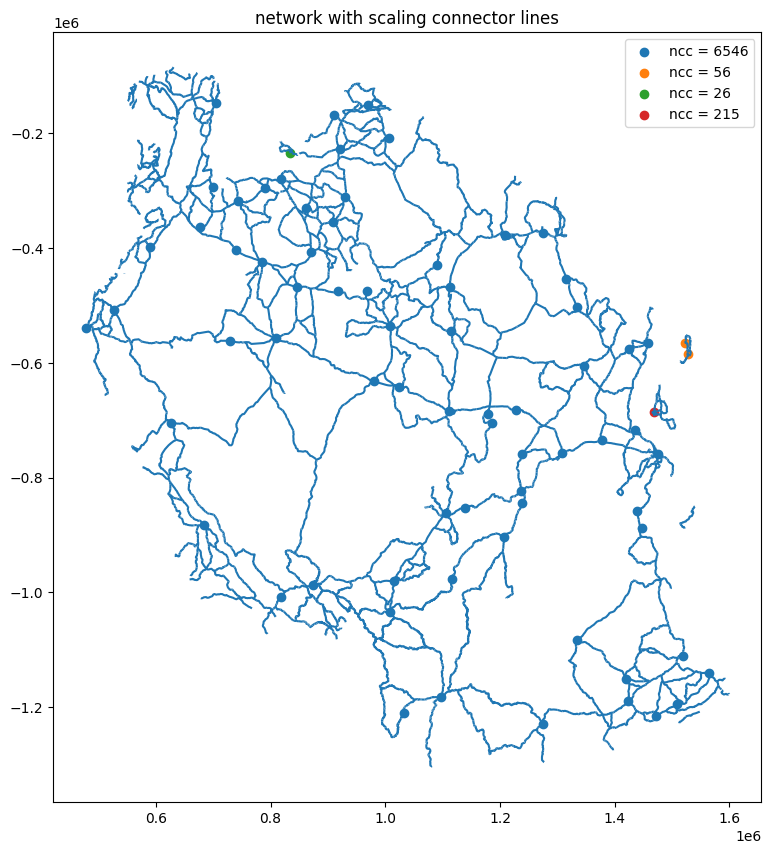

In [17]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))
joined_scaled.plot(ax=ax)
for ncc in ccomps_scaled_df.number_connected_components.value_counts().index:
    ccomps_scaled_df[ccomps_scaled_df.number_connected_components==ncc].plot(ax=ax, label=f'ncc = {ncc}')
ax.legend()
ax.set_title('network with scaling connector lines')
plt.show()

4.5 Assigning the costs to paved and unpaved roads.

In [18]:
cost_per_km_paved = 1
cost_per_km_unpaved = 4
print(uun_joined_scaled.transport_type.value_counts())
uun_joined_scaled['cost'] = np.nan
uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'paved', 'cost'] = (uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'paved']
                                                                              .geometry.length/1000)*cost_per_km_paved
uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'unpaved', 'cost'] = (uun_joined_scaled.loc[uun_joined_scaled.transport_type == 'unpaved']
                                                                                .geometry.length/1000)*cost_per_km_unpaved

unpaved    4695
paved      3142
Name: transport_type, dtype: int64


5. Finding optimal paths between Cities.

In [ ]:
nw = gdf_to_nx(uun_joined_scaled)
all_costs = nx.shortest_path_length(nw, weight = 'cost')
d = {element[0] : {k: v for k, v in element[1].items() if k in centlist_mod} for element in all_costs if element[0] in centlist_mod}